# Trabajo Práctico 2

### Asignatura: Análisis de Series Temporales

#### Docente: Rodrigo Del Rosso
#### Asistentes: Sebastian Calcagno - Fernando Martinez

#### Integrantes:
- Del Villar, Javier Alonso
- Otrino, Facundo Damián
- Pistoya, Haydeé Soledad
- Rojas, Mariano Arturo
- Sorza, Edwin Andrés
- Vaillard, Leandro Carlos

In [2]:
library(readr)
library(tseries)
library(vars)
library(urca)
library(lmtest)
library(forecast)
library(ggplot2)
library(reshape2)
#devtools::install_github("KevinKotze/tsm")
#library(tsm)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest



In [3]:
# FUNCION INCORRELACION

# Cargo la siguiente funci�n de incorrelaci�n que realiza un test de Ljung-Box o Box-Pierce para distintos lags
Incorrelation <- function(ts, type = c("Ljung-Box","Box-Pierce"), fitdf = 0){
  p_ljung_box = NULL
  s_ljung_box = NULL
  for(i in 0:(length(ts)/4)){
    p_ljung_box[i] = Box.test(ts,lag = i,type = type,fitdf = fitdf)$p.value
    s_ljung_box[i] = Box.test(ts,lag = i,type = type,fitdf = fitdf)$statistic
  }
  table = data.frame(j = 1:(length(ts)/4),
                     P_Value = p_ljung_box,
                     Statistic = s_ljung_box)
  return(table)
}

In [4]:
imported <- read_csv("../input/serie-carne/serie-tiempo-indicadores-mensuales-bovinos.csv", col_types = cols(indice_tiempo = col_date(format = "%Y-%m")))

kgVivo <- ts(imported$novillo_precio_kilo_vivo_dolares, frequency = 12, start = c(1998, 01))
faenaTotal <- ts(imported$faena_total_pais / 1000000, frequency = 12, start = c(1998, 01))
consumoInterno <- ts(imported$consumo_interno_per_capita_kg_por_habitante, frequency = 12, start = c(1998, 01))

## Data Analysis

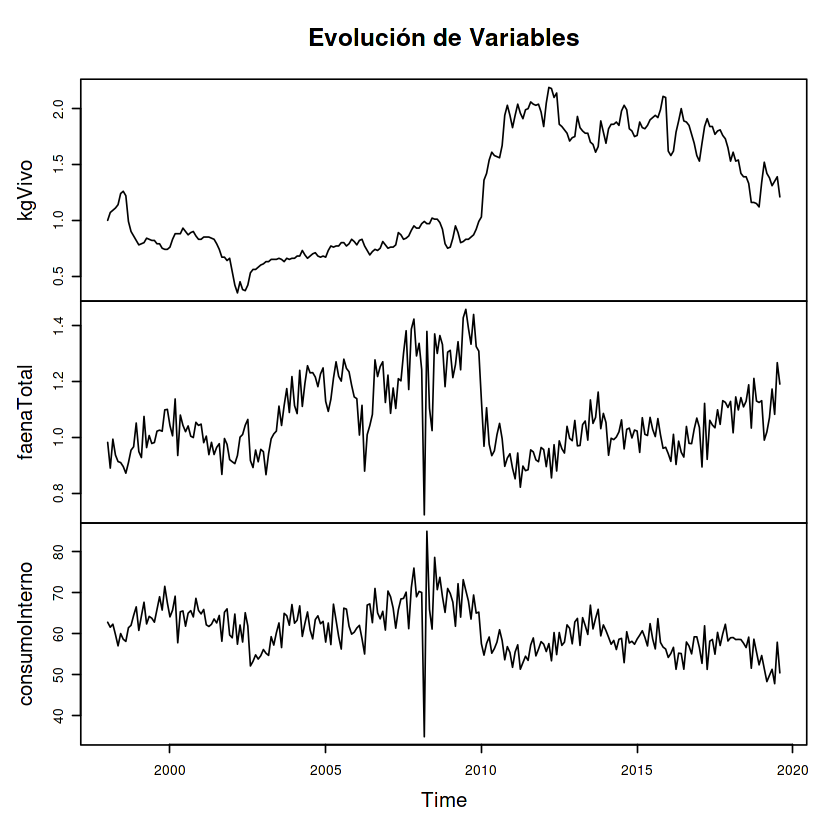

In [5]:
plot(cbind(kgVivo, faenaTotal, consumoInterno), main="Evolución de Variables")

### Analizo Autocorrelacion

Planteo el test de Ljung-Box. 

Si rechazo H<sub>0</sub> significa que hay coeficientes de autocorrelación distintos a cero.

**Autoplot**: Grafico los p-value para distintos lags

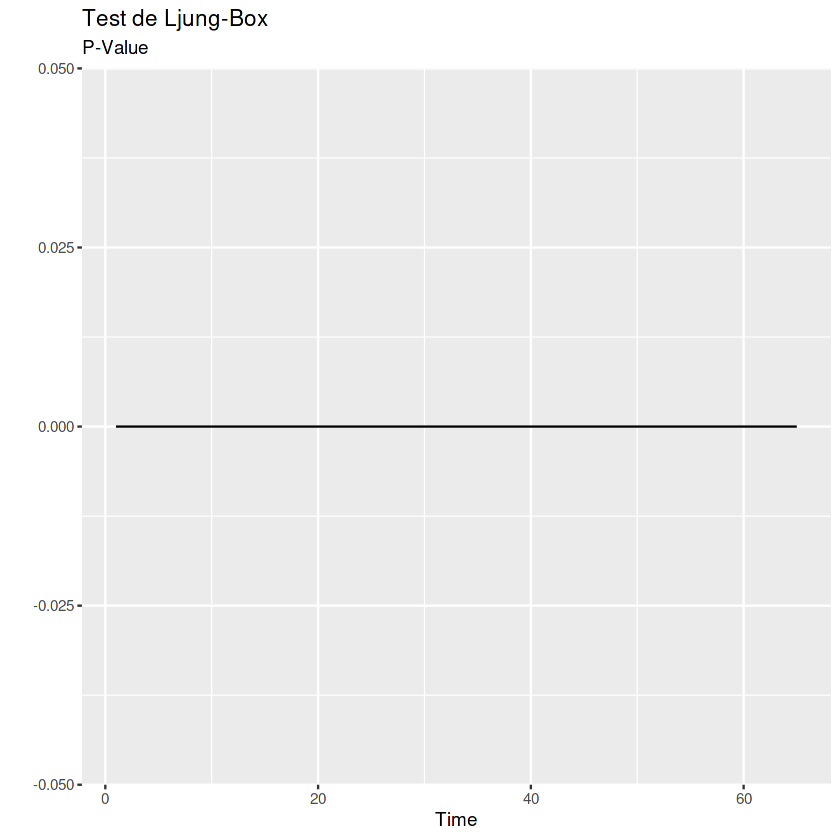

In [6]:
incoKgVivo = Incorrelation(kgVivo,"Ljung-Box")
autoplot(ts(incoKgVivo$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("") 

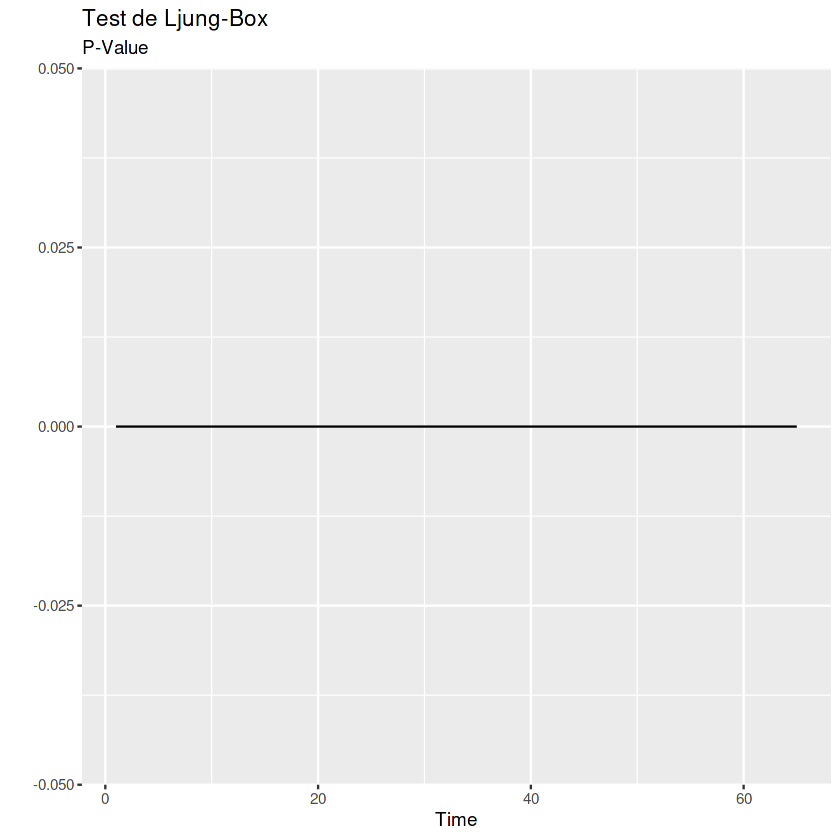

In [7]:
incoFaenaTotal = Incorrelation(kgVivo,"Ljung-Box")
autoplot(ts(incoFaenaTotal$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

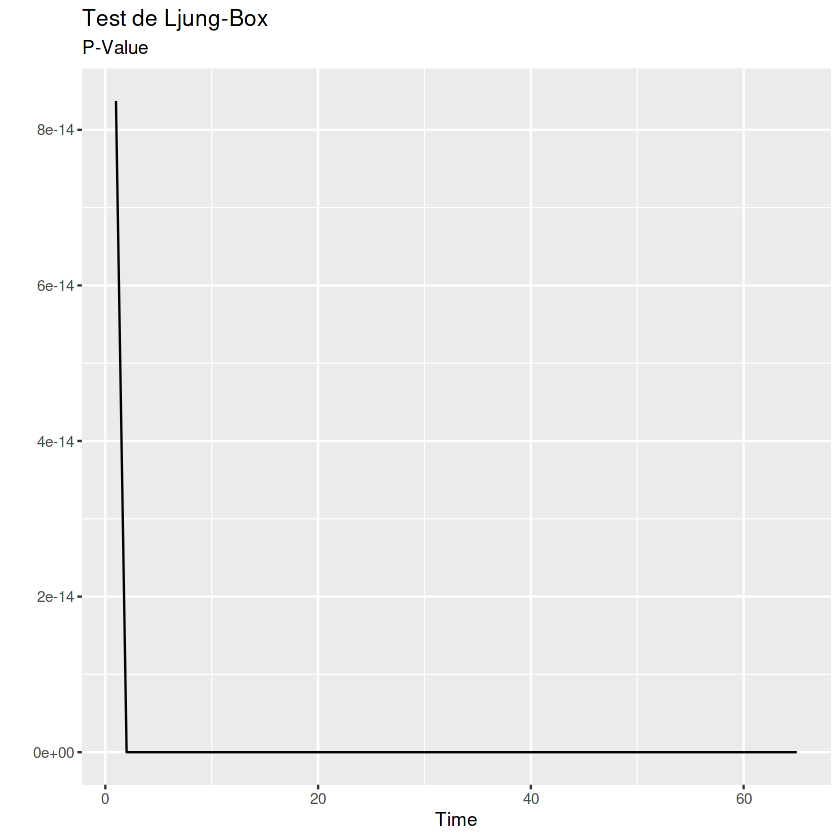

In [8]:
incoConsumoInterno = Incorrelation(consumoInterno,"Ljung-Box")
autoplot(ts(incoConsumoInterno$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

### Analisis de Estacionareidad

#### Dickey Fuller
- H<sub>0</sub>: La serie tiene raíces unitarias (no es estacionaria)
- H<sub>1</sub>: La serie no tiene raíces unitarias (es estacionaria)

##### Nota
adf.test supone una cantidad de **lags** en base a trunc((length of (x)-1)^(1/3)).

#### Series Originales


In [9]:
adf_kgVivo <- adf.test(kgVivo, alternative = "stationary", k = 12)
print(adf_kgVivo)
adf_faenaTotal <- adf.test(faenaTotal, alternative = "stationary", k = 12)
print(adf_faenaTotal)
adf_consumoInterno <- adf.test(consumoInterno, alternative = "stationary", k = 12)
print(adf_consumoInterno)


	Augmented Dickey-Fuller Test

data:  kgVivo
Dickey-Fuller = -2.0366, Lag order = 12, p-value = 0.5604
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  faenaTotal
Dickey-Fuller = -2.3885, Lag order = 12, p-value = 0.4123
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  consumoInterno
Dickey-Fuller = -2.7761, Lag order = 12, p-value = 0.249
alternative hypothesis: stationary



#### Series Diferenciadas

In [10]:
diff_log_kgVivo <- diff(log10(kgVivo))
diff_log_faenaTotal <- diff(log10(faenaTotal))
diff_log_consumoInterno <- diff(log10(consumoInterno))

adf_diff_log_kgVivo <- adf.test(diff_log_kgVivo, alternative = "stationary", k = 12)
print(adf_diff_log_kgVivo)
adf_diff_log_faenaTotal <- adf.test(diff_log_faenaTotal, alternative = "stationary", k = 12)
print(adf_diff_log_faenaTotal)
adf_diff_log_consumoInterno <- adf.test(diff_log_consumoInterno, alternative = "stationary", k = 12)
print(adf_diff_log_consumoInterno)

Warning message in adf.test(diff_log_kgVivo, alternative = "stationary", k = 12):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_kgVivo
Dickey-Fuller = -4.5816, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(diff_log_faenaTotal, alternative = "stationary", k = 12):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_faenaTotal
Dickey-Fuller = -4.6299, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(diff_log_consumoInterno, alternative = "stationary", :
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_consumoInterno
Dickey-Fuller = -4.8894, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary



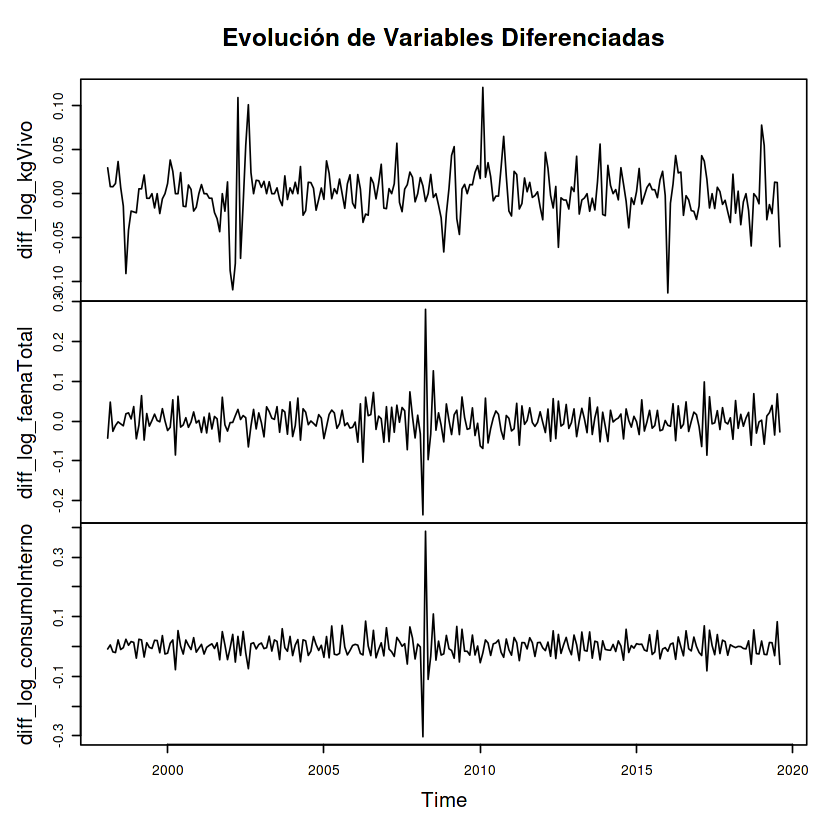

In [11]:
plot(cbind(diff_log_kgVivo, diff_log_faenaTotal, diff_log_consumoInterno), main="Evolución de Variables Diferenciadas")

### KPSS
- H<sub>0</sub>: Estacionario
- H<sub>1</sub>: No estacionario

##### Nota

Si una serie no es estacionaria y hay que transformarla, para el modelo VAR hay que transformar ambas series.

##### Resultados
- kgVivo = 0.1 -> No Rechazo H<sub>0</sub>, **serie Estacionaria**
- faenaTotal = 0.1 -> No Rechazo H<sub>0</sub>, **serie Estacionaria**
- consumoInterno = 0.1 -> No Rechazo H<sub>0</sub>, **serie Estacionaria**

In [12]:
#diff_log_kgVivo, diff_log_faenaTotal, diff_log_consumoInterno

kpss.test(diff_log_kgVivo)
kpss.test(diff_log_faenaTotal)
kpss.test(diff_log_consumoInterno)

Warning message in kpss.test(diff_log_kgVivo):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  diff_log_kgVivo
KPSS Level = 0.11716, Truncation lag parameter = 5, p-value = 0.1


Warning message in kpss.test(diff_log_faenaTotal):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  diff_log_faenaTotal
KPSS Level = 0.029886, Truncation lag parameter = 5, p-value = 0.1


Warning message in kpss.test(diff_log_consumoInterno):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  diff_log_consumoInterno
KPSS Level = 0.032776, Truncation lag parameter = 5, p-value = 0.1


## Metodo VAR

#### Transformación de los Datos

In [13]:
kgVivo <- diff(log10(kgVivo))
faenaTotal <- diff(log10(faenaTotal))
consumoInterno <- diff(log10(consumoInterno))

In [14]:
dat.bv <- cbind(kgVivo, faenaTotal,consumoInterno)
colnames(dat.bv) <- c("KGVivo", "FaenaTotal", "ConsumoInterno")

#### Selección del lag del modelo VAR con menor criterio de información

Todos los metodos sugieren **Lag = 12**

In [15]:
info <- VARselect(dat.bv, lag.max = 12)
info$selection 

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12     12      2     12

#### Planteo las condiciones de estabilidad del VAR

In [16]:
bv.est <- VAR(dat.bv, p = 12)
summary(bv.est)


VAR Estimation Results:
Endogenous variables: KGVivo, FaenaTotal, ConsumoInterno 
Deterministic variables: const 
Sample size: 247 
Log Likelihood: 1827.817 
Roots of the characteristic polynomial:
0.9925 0.9925 0.9867 0.9656 0.9656 0.9571 0.9571 0.9504 0.9504 0.9439 0.9439 0.9133 0.9133 0.8936 0.8901 0.8901 0.886 0.886 0.8745 0.8745 0.8723 0.8723 0.8533 0.8533 0.8519 0.8519 0.8453 0.8453 0.8201 0.8201 0.8179 0.8099 0.8099 0.6264 0.6264 0.2581
Call:
VAR(y = dat.bv, p = 12)


Estimation results for equation KGVivo: 
KGVivo = KGVivo.l1 + FaenaTotal.l1 + ConsumoInterno.l1 + KGVivo.l2 + FaenaTotal.l2 + ConsumoInterno.l2 + KGVivo.l3 + FaenaTotal.l3 + ConsumoInterno.l3 + KGVivo.l4 + FaenaTotal.l4 + ConsumoInterno.l4 + KGVivo.l5 + FaenaTotal.l5 + ConsumoInterno.l5 + KGVivo.l6 + FaenaTotal.l6 + ConsumoInterno.l6 + KGVivo.l7 + FaenaTotal.l7 + ConsumoInterno.l7 + KGVivo.l8 + FaenaTotal.l8 + ConsumoInterno.l8 + KGVivo.l9 + FaenaTotal.l9 + ConsumoInterno.l9 + KGVivo.l10 + FaenaTotal.l10 + Consumo

### Analisis de Residuos


#### Planteo la prueba de autocorrelación para los residuos mediante un Portmanteau-test

- H<sub>0</sub>: No hay Correlación

Un p-value mayor a 0,05 indica ausencia de correlaci�n.

##### Resultados
P-Value = < 2.2e-16

**Rechazo H<sub>0</sub>, estan correlacionados**

In [17]:
bv.serial <- serial.test(bv.est, lags.pt = 12, type = "PT.asymptotic")
bv.serial


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object bv.est
Chi-squared = 38.866, df = 0, p-value < 2.2e-16

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object bv.est
Chi-squared = 38.866, df = 0, p-value < 2.2e-16



Los residuos por separado ajustan a un ruido blanco.

Los residuos de cada ecuación del modelo son los mejores proxys a los errores poblacionales, los cuales se supone que a nivel individual de ecuación están incorrelacionados, pero tomando el error de cada ecuación en el mismo momento de tiempo están correlacionados. Esto se da porque lo novedoso de este modelo es que las variables están interrelacionadas entre sí, y el nexo de conexión es el shock de cada ecuación, por lo que, si uno contempla que ante el incremento de una variable, otra debe moverse en tal sentido o en tal dirección, su vinculación es por el error que están correlacionados.

#### Variable: KGVivo

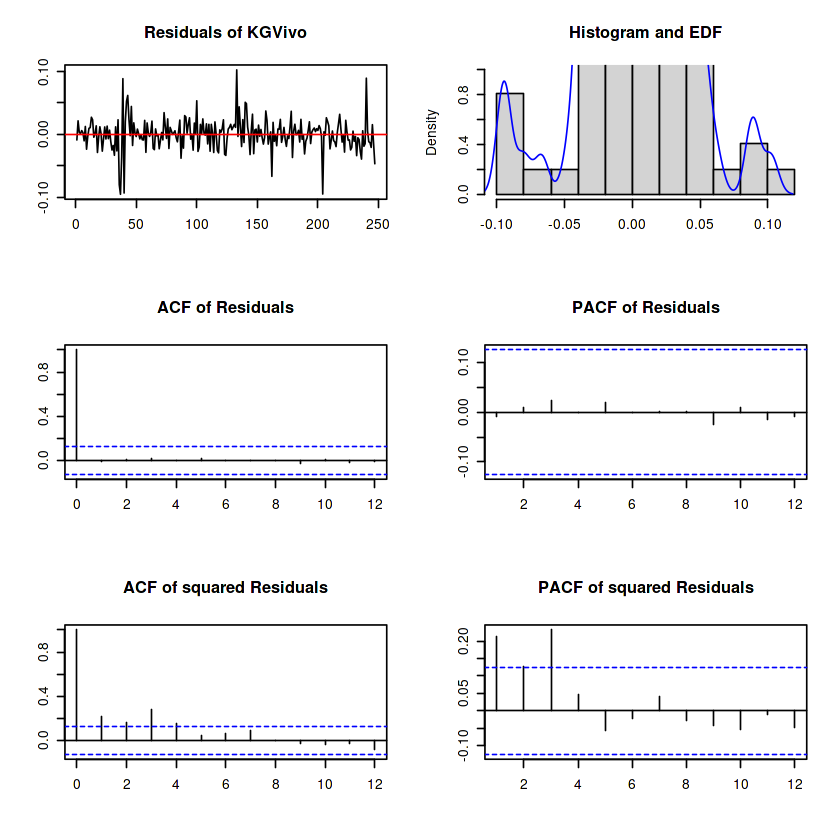

In [18]:
plot(bv.serial, names = "KGVivo")

#### Variable: FaenaTotal

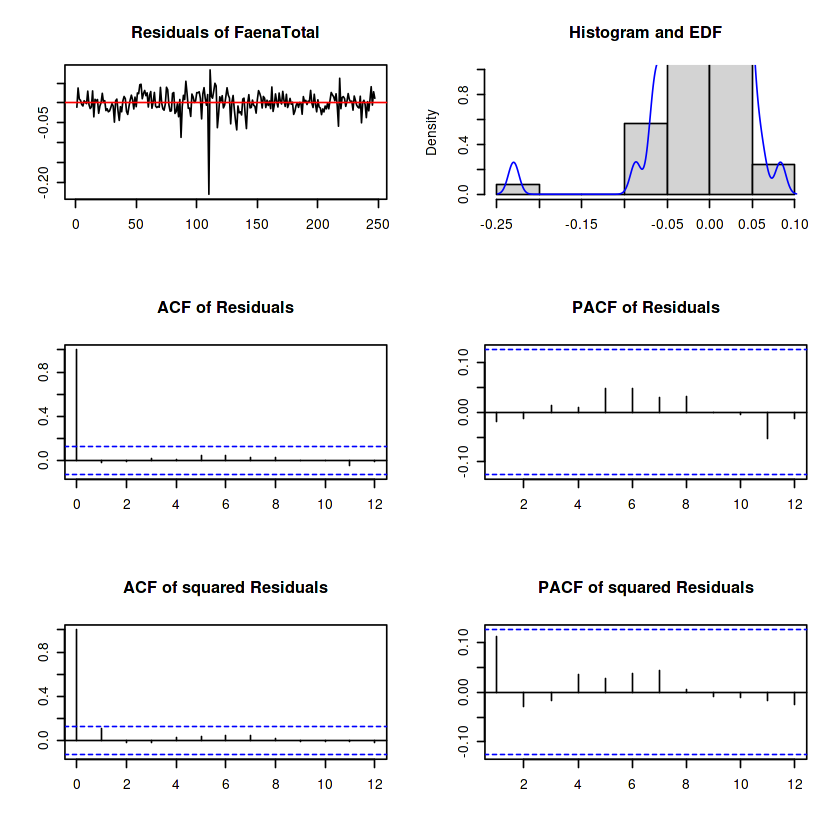

In [19]:
plot(bv.serial, names = "FaenaTotal")

#### Variable: ConsumoInterno

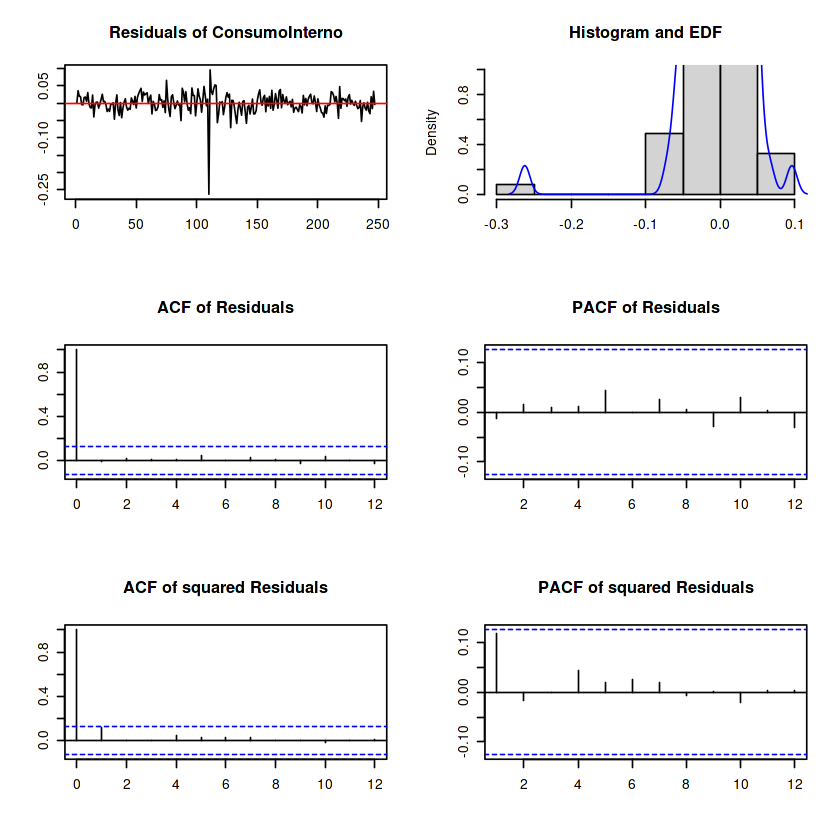

In [20]:
plot(bv.serial, names = "ConsumoInterno")

#### Verifico la homocedasticidad de los residuos

- H<sub>0</sub>: Homocedástico. La varianza es constante.

##### Resultados

P-Value = 0.008828

**No Rechazo H<sub>0</sub>, los residuos son homocedásticos**

In [21]:
bv.arch <- arch.test(bv.est, lags.multi = 12, multivariate.only = TRUE)
bv.arch


	ARCH (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 504.82, df = 432, p-value = 0.008828

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 504.82, df = 432, p-value = 0.008828



#### Verifico la Normalidad de los residuos

- H<sub>0</sub>: Residuos Normales

##### Resultados

Jarque-Bera P-Value = < 2.2e-16

**Rechazo H<sub>0</sub>, los residuos no poseen distribucion normal**

In [22]:
bv.norm <- normality.test(bv.est, multivariate.only = TRUE)
bv.norm

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 4444.2, df = 6, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 259.93, df = 3, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 4184.3, df = 3, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 4444.2, df = 6, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 259.93, df = 3, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object bv.est
Chi-squared = 4184.3, df = 3, p-value < 2.2e-16




#### Estabilidad estructural de los residuos

Más detalle: https://www.stata.com/features/overview/cumulative-sum-test/

##### Resultados

**No hay quiebre estructural que atraviese los intervalos de confianza.**

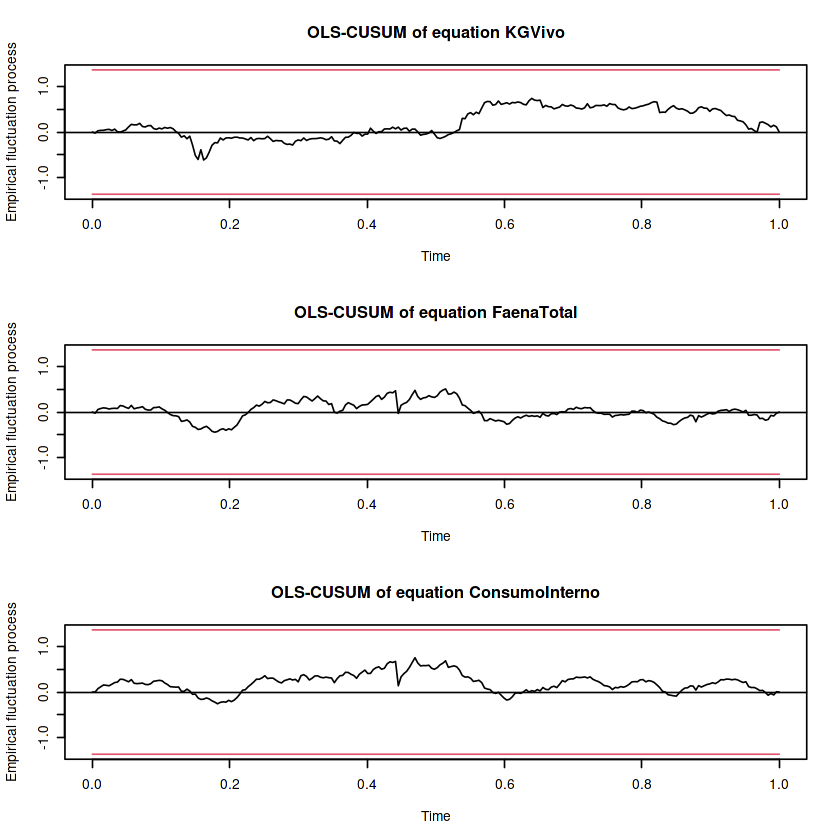

In [23]:
bv.cusum <- stability(bv.est, type = "OLS-CUSUM")
plot(bv.cusum)

#### Causalidad de Granger

- H<sub>0</sub>: 

#### Nota

Un p-value menor a 0.05 indica causalidad de Granger.

#### Nota Causalidad Instantanea

La causalidad instantánea postula si puede rechazarse o no esta conjetura entre las variables empleadas, dado que puede ser que la causalidad entre ambas variables sea en un momento particular del tiempo y que no sea una causalidad en todo momento.
Se dice que una causalidad instantánea está ocurriendo, si el valor actual de una variable es predecido mejor si el valor presente de la otra variable es incluido en la predicción que si no lo fuera.



In [24]:
bv.cause.ConsumoInterno <- causality(bv.est, cause = c("KGVivo","FaenaTotal"))
bv.cause.ConsumoInterno

$Granger

	Granger causality H0: KGVivo FaenaTotal do not Granger-cause
	ConsumoInterno

data:  VAR object bv.est
F-Test = 1.594, df1 = 24, df2 = 630, p-value = 0.0365


$Instant

	H0: No instantaneous causality between: KGVivo FaenaTotal and
	ConsumoInterno

data:  VAR object bv.est
Chi-squared = 109.55, df = 2, p-value < 2.2e-16



In [25]:
bv.cause.FaenaTotal <- causality(bv.est, cause = c("KGVivo","ConsumoInterno"))
bv.cause.FaenaTotal

$Granger

	Granger causality H0: KGVivo ConsumoInterno do not Granger-cause
	FaenaTotal

data:  VAR object bv.est
F-Test = 1.5872, df1 = 24, df2 = 630, p-value = 0.03785


$Instant

	H0: No instantaneous causality between: KGVivo ConsumoInterno and
	FaenaTotal

data:  VAR object bv.est
Chi-squared = 109.6, df = 2, p-value < 2.2e-16



In [26]:
bv.cause.kgVivo <- causality(bv.est, cause = c("ConsumoInterno","FaenaTotal"))
bv.cause.kgVivo

$Granger

	Granger causality H0: FaenaTotal ConsumoInterno do not Granger-cause
	KGVivo

data:  VAR object bv.est
F-Test = 0.80429, df1 = 24, df2 = 630, p-value = 0.7335


$Instant

	H0: No instantaneous causality between: FaenaTotal ConsumoInterno and
	KGVivo

data:  VAR object bv.est
Chi-squared = 2.9824, df = 2, p-value = 0.2251



In [27]:
#############CAUSALIDAD DE GRANGER#############
# H0 : "Serie y" no causa en el sentido de Granger a "serie X" ---> p-value > 0.05 no rechazo H0
# H1 : "Serie y" causa en el sentido de Granger a "serie X"    ---> p-value < 0.05 rechazo H0


grangertest(diff_log_kgVivo ~ diff_log_faenaTotal, order = 12) # 0.2053192 NO RECHAZO H0, NO HAY CAUSALIDAD EN EL SENTIDO DE GRANGER .FAENA NO CAUSA ( NO EXPLICA) EN EL SENTIDO DE GRANGER A KG VIVO.
grangertest(diff_log_kgVivo ~ diff_log_consumoInterno, order = 12) # 0.7370048  NO RECHAZO H0, NO HAY CAUSALIDAD EN EL SENTIDO DE GRANGER . CONSUMO INTERNO NO CAUSA (NO EXPLICA) EN EL SENTIDO DE GRANGER A KG VIVO.

grangertest(diff_log_faenaTotal ~ diff_log_kgVivo, order = 12)  # 0.1349988 NO RECHAZO H0, NO HAY CAUSALIDAD EN EL SENTIDO DE GRANGER . KG VIVO NO CAUSA (NO EXPLICA) EN EL SENTIDO DE GRANGER A FAENA TOTAL.
grangertest(diff_log_faenaTotal ~ diff_log_consumoInterno, order = 12) # 0.0008522876 RECHAZO H0. HAY CAUSALIDAD EN EL SENTIDO DE GRANGER. CONSUMO INTERNO  CAUSA (EXPLICA) EN EL SENTIDO DE GRANGER A FAENA TOTAL.

grangertest(diff_log_consumoInterno ~ diff_log_kgVivo, order = 12)  # 0.05146946  - EN EL BORDE... -NO RECHAZO H0, NO HAY CAUSALIDAD EN EL SENTIDO DE GRANGER . KG VIVO NO CAUSA (NO EXPLICA) EN EL SENTIDO DE GRANGER A CONSUMO INTERNO.
grangertest(diff_log_consumoInterno ~ diff_log_faenaTotal, order = 12) # 0.5353987 NO RECHAZO H0, NO HAY CAUSALIDAD EN EL SENTIDO DE GRANGER . FAENA TOTAL NO CAUSA (NO EXPLICA) EN EL SENTIDO DE GRANGER A CONSUMO INTERNO.



,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,1.325215,0.2053192


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,0.7141112,0.7370048


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,1.474625,0.1349988


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,2.92931,0.0008522876


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,1.787062,0.05146946


,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,222,NA,NA,NA
2,234,-12,0.9122838,0.5353987


#### Funcion Impulso - Respuesta


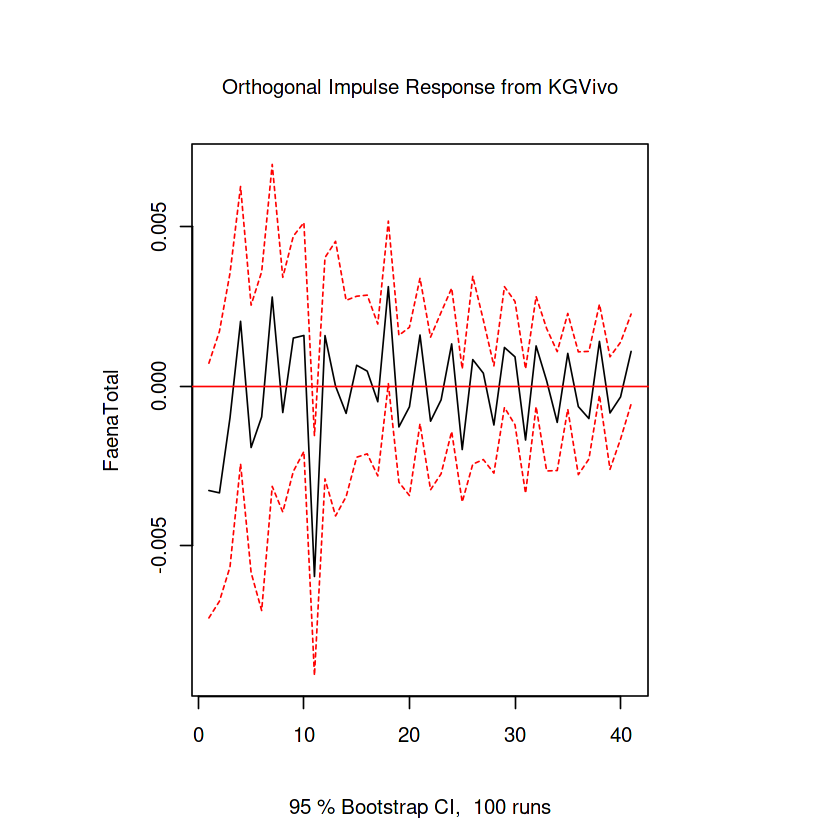

In [60]:
irf_kg_vivo_faena <- irf(bv.est, impulse = "KGVivo", response = "FaenaTotal",n.ahead = 40, boot = TRUE)
plot(irf_kg_vivo_faena)

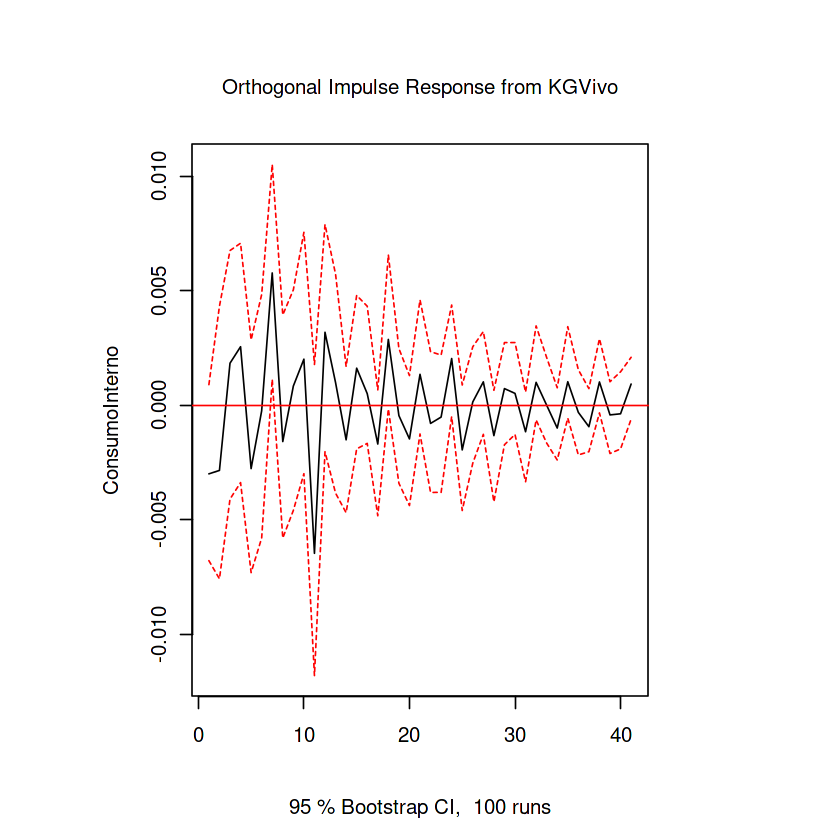

In [61]:
irf_kg_vivo_Consumo <- irf(bv.est, impulse = "KGVivo", response = "ConsumoInterno",n.ahead = 40, boot = TRUE)
plot(irf_kg_vivo_Consumo )

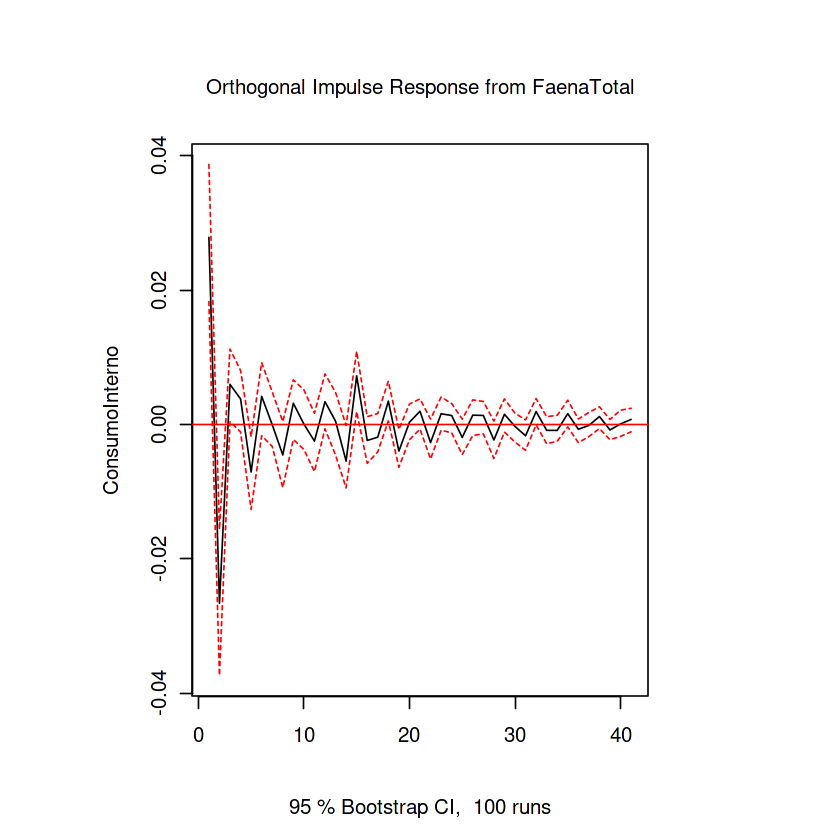

In [62]:
irf_Faena_Consumo <- irf(bv.est, impulse = "FaenaTotal", response = "ConsumoInterno",n.ahead = 40, boot = TRUE)
plot(irf_Faena_Consumo)

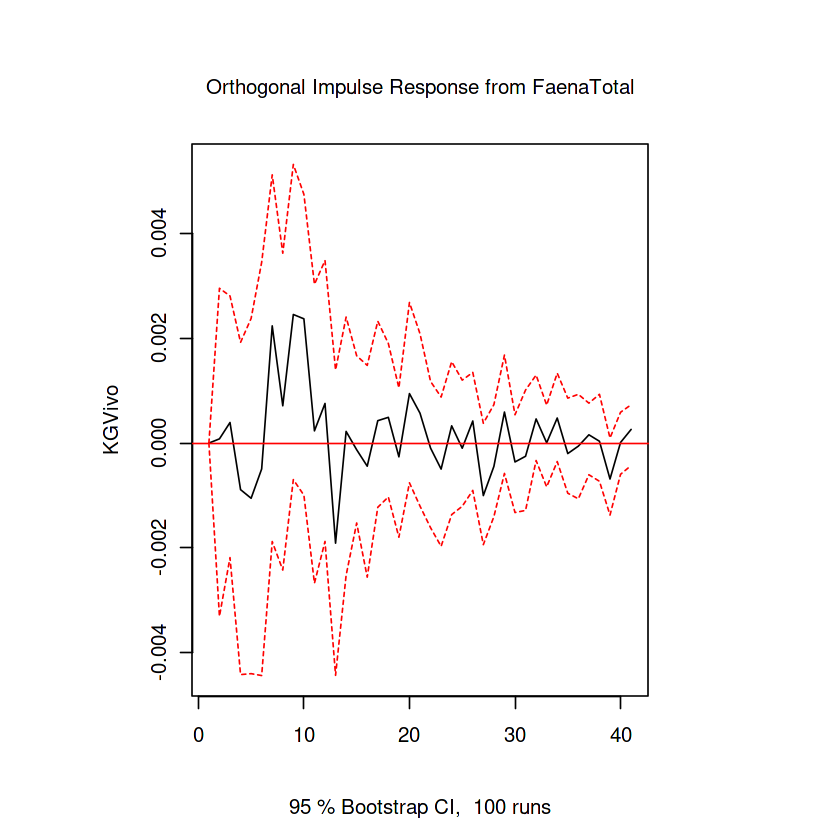

In [63]:
irf_Faena_kg_vivo <- irf(bv.est, impulse = "FaenaTotal", response = "KGVivo",n.ahead = 40, boot = TRUE)
plot(irf_Faena_kg_vivo)

[1] 40

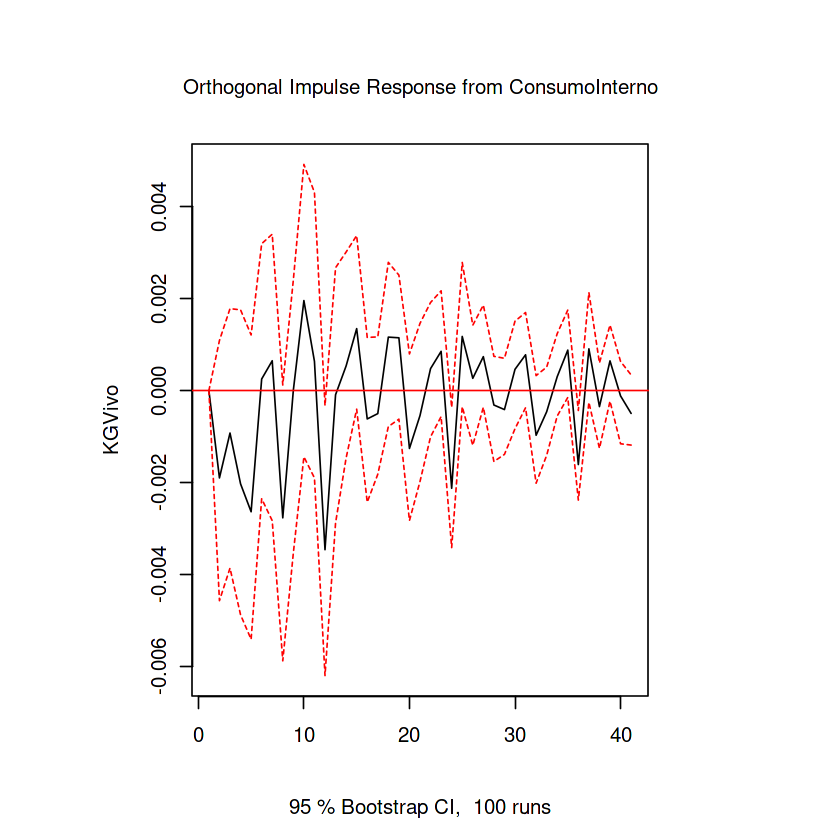

In [64]:
irf_Consumo_KgVivo <- irf(bv.est, impulse = "ConsumoInterno", response = "KGVivo",n.ahead = 40, boot = TRUE)
plot(irf_Consumo_KgVivo)

40

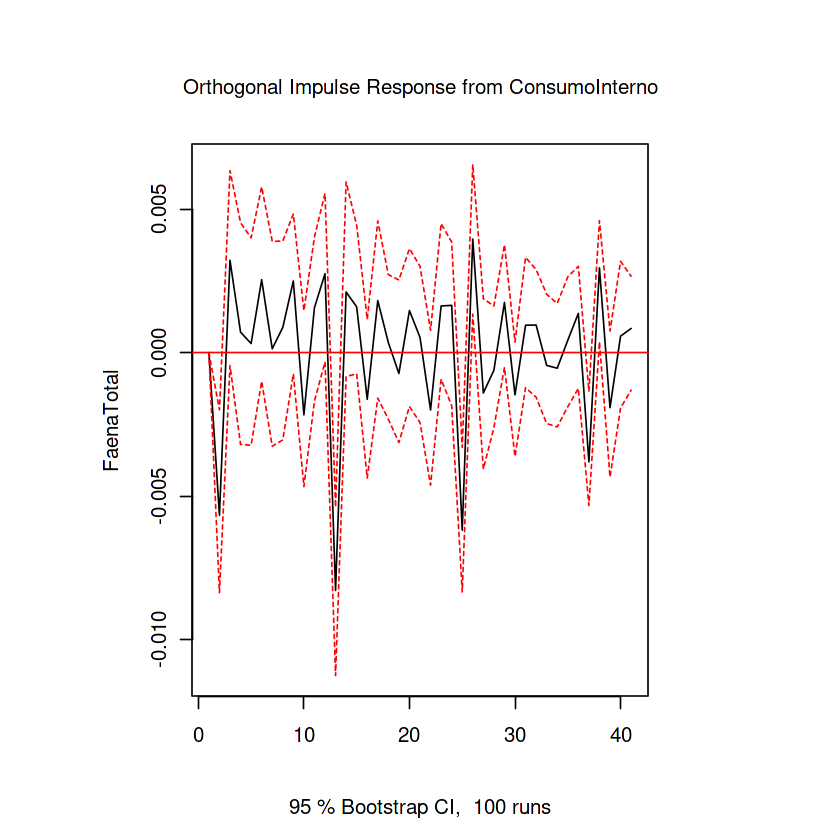

In [65]:
irf_Consumo_Faena <- irf(bv.est, impulse = "ConsumoInterno", response = "FaenaTotal",n.ahead = 40, boot = TRUE)
plot(irf_Consumo_Faena)

#### Descomposición de las Varianzas de las Variables

#### Nota

Indica la cantidad de información que cada variable aporta a las otras variables en la autorregresión. 

Determina cuánto de la varianza del error de pronóstico de cada una de las variables puede explicarse por shocks de las otras variables.

El grafico me indica que % de la variabilidad está explicada por cada variable.


$KGVivo
         KGVivo   FaenaTotal ConsumoInterno
 [1,] 1.0000000 0.000000e+00    0.000000000
 [2,] 0.9953443 8.367255e-06    0.004647325
 [3,] 0.9940950 2.049135e-04    0.005700097
 [4,] 0.9880120 1.192981e-03    0.010794988
 [5,] 0.9782615 2.539873e-03    0.019198627
 [6,] 0.9779299 2.834589e-03    0.019235461
 [7,] 0.9715473 8.898220e-03    0.019554481
 [8,] 0.9625037 9.285783e-03    0.028210548
 [9,] 0.9556678 1.632594e-02    0.028006300
[10,] 0.9453514 2.260710e-02    0.032041483
[11,] 0.9448975 2.263700e-02    0.032465512
[12,] 0.9313066 2.296437e-02    0.045729056

$FaenaTotal
          KGVivo FaenaTotal ConsumoInterno
 [1,] 0.01216835  0.9878317     0.00000000
 [2,] 0.01649140  0.9591403     0.02436832
 [3,] 0.01659515  0.9523516     0.03105328
 [4,] 0.01949718  0.9493028     0.03120000
 [5,] 0.02118330  0.9489082     0.02990855
 [6,] 0.02149135  0.9446108     0.03389784
 [7,] 0.02662812  0.9397480     0.03362392
 [8,] 0.02662882  0.9397925     0.03357870
 [9,] 0.02774775  0.

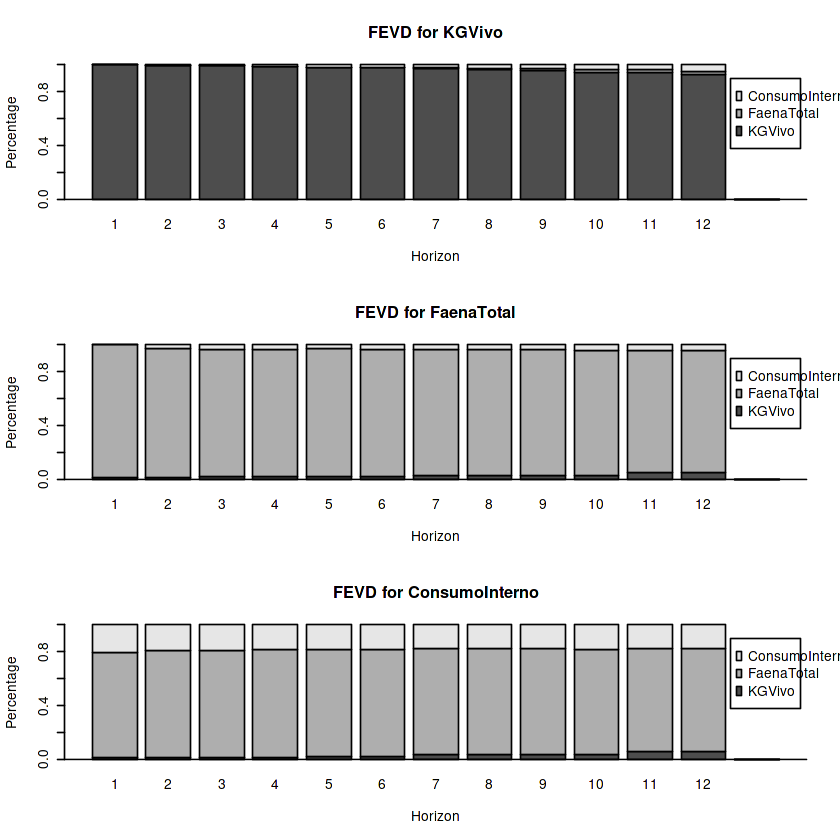

In [57]:
bv.vardec <- fevd(bv.est, n.ahead = 12)
bv.vardec
plot(bv.vardec)

## Forecast

In [35]:
train_kgVivo <- window(kgVivo,start = c(1998,1), end = c(2017,12))
train_faenaTotal <- window(faenaTotal,start = c(1998,1), end = c(2017,12))
train_consumoInterno <- window(consumoInterno,start = c(1998,1), end = c(2017,12))

Warning message in window.default(x, ...):
“'start' value not changed”
Warning message in window.default(x, ...):
“'start' value not changed”
Warning message in window.default(x, ...):
“'start' value not changed”


In [36]:
test_kgVivo <- window(kgVivo, start = c(2018,01), end = c(2018,12))
test_faenaTotal <- window(faenaTotal, start = c(2018,01), end = c(2018,12))
test_consumoInterno <- window(consumoInterno, start = c(2018,01), end = c(2018,12))

In [37]:
dat.bv1 <- cbind(train_kgVivo, train_faenaTotal, train_consumoInterno)
colnames(dat.bv1) <- c("train_KGVivo", "train_FaenaTotal", "train_ConsumoInterno")

#### Planteo el modelo VAR

In [38]:
bv.est1 <- VAR(dat.bv1, p = 12)

#### Realizo la predicción con el modelo VAR

$train_KGVivo
              fcst       lower      upper         CI
 [1,] -0.015678268 -0.06710272 0.03574618 0.05142445
 [2,]  0.023152617 -0.03069493 0.07700016 0.05384754
 [3,] -0.007267085 -0.06134074 0.04680657 0.05407365
 [4,]  0.007030730 -0.04756507 0.06162653 0.05459580
 [5,]  0.003152007 -0.05202711 0.05833112 0.05517911
 [6,]  0.005825990 -0.04942351 0.06107549 0.05524950
 [7,]  0.003224305 -0.05232083 0.05876944 0.05554513
 [8,]  0.006463641 -0.04951990 0.06244718 0.05598354
 [9,] -0.002652276 -0.05885754 0.05355299 0.05620527
[10,] -0.006680747 -0.06336767 0.05000617 0.05668692
[11,]  0.006837983 -0.04993287 0.06360884 0.05677086
[12,]  0.006040673 -0.05129128 0.06337263 0.05733195

$train_FaenaTotal
              fcst       lower      upper         CI
 [1,]  0.007308032 -0.05205538 0.06667145 0.05936342
 [2,] -0.029299905 -0.10212581 0.04352600 0.07282591
 [3,]  0.030053799 -0.04409003 0.10419763 0.07414383
 [4,] -0.021708209 -0.09609556 0.05267914 0.07438735
 [5,]  0.0224

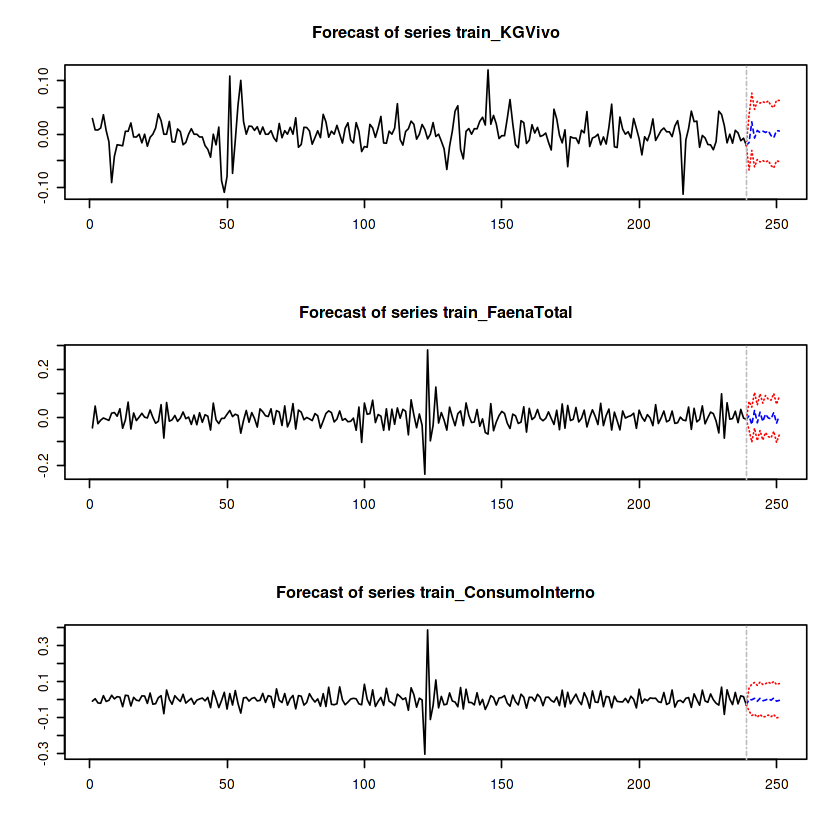

In [39]:
fcast <- predict(bv.est1, n.ahead = 12, ci = 0.95)
plot(fcast)
fcast

In [40]:
library(Metrics)


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




## Resultados AutoML vs VAR

In [41]:
var_predicted_kgVivo = c(fcast$fcst$train_KGVivo[,1])
var_actual_kgVivo = c(test_kgVivo)

autoML_predicted_kgVivo = c(1.519001,1.620031,1.528862,1.548675,1.412877,1.396996,1.407215,1.33882,1.150262,1.187758,1.170305,1.145038,1.402444,1.563664,1.428374,1.402667,1.335377,1.390449,1.430178)
autoML_actual_kgVivo = c(1.61,1.53,1.54,1.42,1.39,1.39,1.33,1.16,1.16,1.15,1.12,1.34,1.52,1.42,1.38,1.31,1.35,1.39,1.21)

mase(var_actual_kgVivo, var_predicted_kgVivo)
mase(autoML_actual_kgVivo, autoML_predicted_kgVivo)

[1] 0.5904028

[1] 1.055166

In [42]:
var_predicted_FaenaTotal = c(fcast$fcst$train_FaenaTotal[,1])
var_actual_FaenaTotal = c(test_faenaTotal)

autoML_predicted_FaenaTotal = c(1104582,1092639,1063432,1120974,1104500,1122192,1115927,1112888,1129997,1092290,1106592,1113690,1119637,1111574,1036437,1072498,1099191,1119777,1122864)
autoML_actual_FaenaTotal = c(1016032,1144461,1097949,1142051,1108796,1129144,1187806,1032950,1210767,1129775,1124678,1130946,989680,1019251,1070475,1172685,1082169,1267109,1190601)

mase(var_actual_FaenaTotal, var_predicted_FaenaTotal)
mase(autoML_actual_FaenaTotal, autoML_predicted_FaenaTotal)

[1] 0.2775129

[1] 0.7282455

In [43]:
var_predicted_ConsumoInterno = c(fcast$fcst$train_ConsumoInterno[,1])
var_actual_ConsumoInterno = c(test_consumoInterno)

autoML_predicted_ConsumoInterno = c(54.811588,56.929138,56.852398,51.838478,53.410934,52.922855,52.751316,54.738731,56.843536,57.308636,55.289936,51.665062,53.344296,55.093906,55.204388,54.903526,52.143898,55.164761,54.604607)
autoML_actual_ConsumoInterno = c(59.06,58.57,58.61,58.57,57.69,56.62,59.16,51.58,58.65,55.52,52.4,54.67,51.46,48.31,49.83,51.31,47.81,57.91,50.45)

mase(var_actual_ConsumoInterno, var_predicted_ConsumoInterno)
mase(autoML_actual_ConsumoInterno, autoML_predicted_ConsumoInterno)

[1] 0.5465501

[1] 1.135257

### Prediccion Futuro

In [44]:
dat.bv2 <- cbind(kgVivo, faenaTotal, consumoInterno)
colnames(dat.bv1) <- c("train_KGVivo", "train_FaenaTotal", "train_ConsumoInterno")
bv.est2 <- VAR(dat.bv2, p = 12)

$kgVivo
              fcst       lower      upper         CI
[1,] -0.0160195322 -0.06812119 0.03608212 0.05210166
[2,]  0.0177946135 -0.03686481 0.07245404 0.05465943
[3,]  0.0205699243 -0.03431286 0.07545271 0.05488279
[4,]  0.0024811346 -0.05281693 0.05777920 0.05529807
[5,] -0.0052640823 -0.06105182 0.05052365 0.05578774
[6,] -0.0008732597 -0.05672168 0.05497516 0.05584842

$faenaTotal
              fcst       lower        upper         CI
[1,]  0.0042652912 -0.05369221  0.062222791 0.05795750
[2,]  0.0327076407 -0.03849758  0.103912865 0.07120522
[3,] -0.0784741915 -0.15101245 -0.005935931 0.07253826
[4,]  0.0262111100 -0.04659059  0.099012813 0.07280170
[5,]  0.0005062286 -0.07393835  0.074950808 0.07444458
[6,] -0.0580022779 -0.13300067  0.016996116 0.07499839

$consumoInterno
            fcst       lower      upper         CI
[1,]  0.01645278 -0.04504728 0.07795283 0.06150006
[2,]  0.02013672 -0.06426500 0.10453844 0.08440172
[3,] -0.06412163 -0.14949846 0.02125521 0.08537683
[4

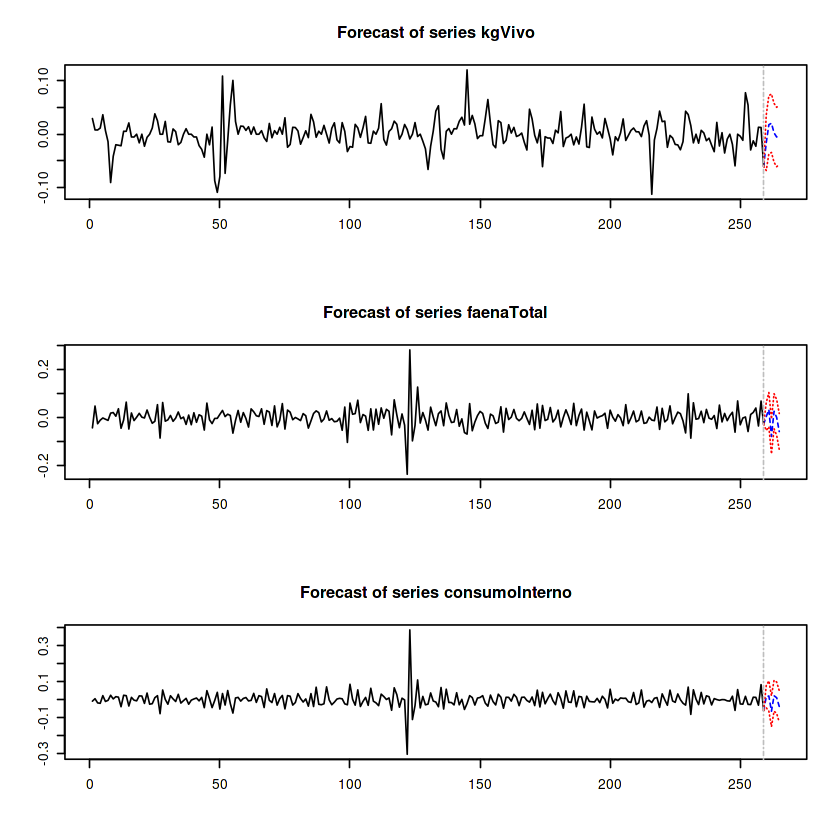

In [45]:
fcastFuturo6 <- predict(bv.est2, n.ahead = 6, ci = 0.95)
plot(fcastFuturo6)
fcastFuturo6

In [46]:
fcastFuturo6$endog

,kgVivo,faenaTotal,consumoInterno
Feb 1998,0.029383778,-0.0427310318,-0.0084507985
Mar 1998,0.008042720,0.0477746533,0.0051877601
Apr 1998,0.007896481,-0.0255833165,-0.0180715340
May 1998,0.011581873,-0.0109387198,-0.0203763939
Jun 1998,0.036516834,-0.0017428034,0.0221888265
Jul 1998,0.006948860,-0.0068400993,-0.0101003269
Aug 1998,-0.014010714,-0.0117149397,-0.0039424108
Sep 1998,-0.090724636,0.0183959509,0.0242669503
Oct 1998,-0.041392685,0.0208558281,0.0040792332
Nov 1998,-0.019744058,0.0055708579,0.0165511325


#### KG Vivo

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1998,1.000000,1.070000,1.090000,1.110000,1.140000,1.240000,1.260000,1.220000,0.990000,0.900000,0.860000,0.820000
1999,0.780000,0.790000,0.800000,0.840000,0.830000,0.820000,0.820000,0.790000,0.790000,0.750000,0.740000,0.740000
2000,0.760000,0.830000,0.880000,0.880000,0.880000,0.930000,0.900000,0.870000,0.890000,0.900000,0.860000,0.830000
2001,0.830000,0.850000,0.850000,0.850000,0.840000,0.830000,0.790000,0.740000,0.670000,0.670000,0.640000,0.660000
2002,0.540000,0.420000,0.350000,0.450000,0.380000,0.370000,0.420000,0.530000,0.560000,0.560000,0.580000,0.600000
2003,0.610000,0.630000,0.630000,0.650000,0.650000,0.650000,0.660000,0.650000,0.630000,0.660000,0.650000,0.660000
2004,0.660000,0.680000,0.680000,0.730000,0.690000,0.660000,0.680000,0.700000,0.710000,0.680000,0.670000,0.680000
2005,0.670000,0.730000,0.770000,0.760000,0.770000,0.770000,0.800000,0.800000,0.770000,0.790000,0.830000,0.810000
2006,0.780000,0.820000,0.830000,0.770000,0.730000,0.690000,0.720000,0.740000,0.730000,0.750000,0.810000,0.780000
2007,0.750000,0.760000,0.760000,0.780000,0.890000,0.870000,0.830000,0.840000,0.860000,0.910000,0.950000,0.930000


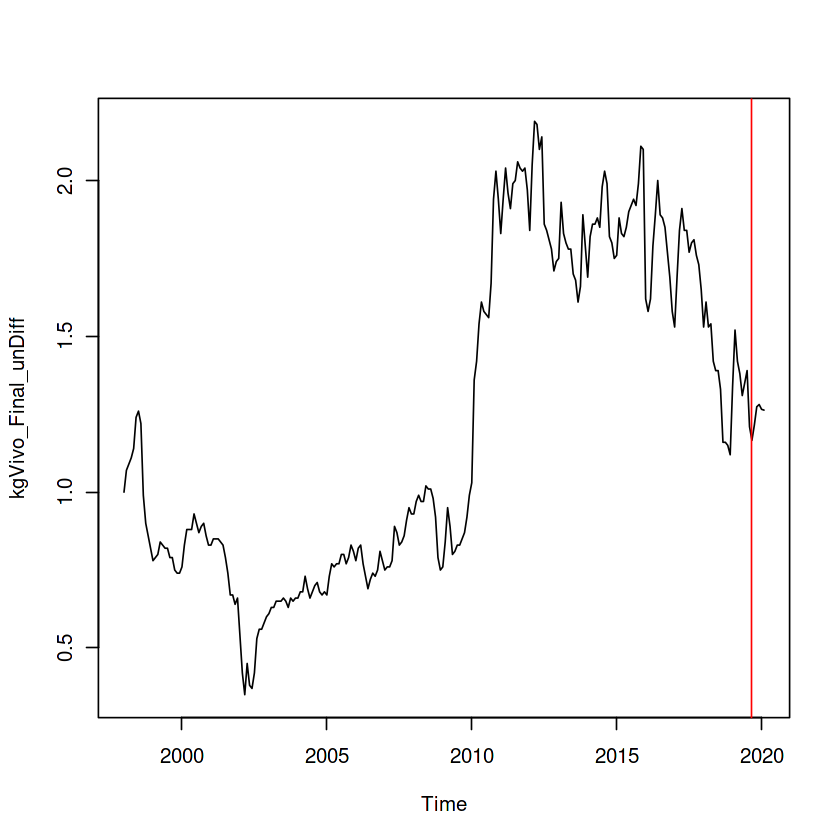

In [47]:
kgVivo_Final = ts(c(
    fcastFuturo6$endog[,1],
    ts(fcastFuturo6$fcst$kgVivo[,1], frequency = 12, start = c(2019, 09))
), frequency = 12, start = c(1998, 02))

kgVivo_Final_unDiff = 10^(diffinv(kgVivo_Final, xi=log10(1)))
kgVivo_Final_unDiff

plot(kgVivo_Final_unDiff)
abline(v=2019.666666666666667, col="red")

#### Faena Total

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1998,0.981503,0.889530,0.992968,0.936164,0.912879,0.909223,0.895015,0.871195,0.908890,0.953602,0.965913,1.050844
1999,0.948672,0.927260,1.074506,0.963026,1.006152,0.977610,0.981162,1.021676,1.025461,1.021556,1.098031,1.099917
2000,1.041838,1.005183,1.137095,0.934731,1.079383,1.042738,1.020005,1.040550,1.003889,0.998873,1.053556,1.042395
2001,1.047060,0.980606,1.004051,0.937681,0.981754,0.938215,0.963735,0.976874,0.866959,0.995446,0.974489,0.919863
2002,0.912177,0.905498,0.934542,1.000301,1.009796,1.042876,1.063835,0.916481,0.891495,0.954068,0.912141,0.956632
2003,0.948291,0.865925,0.940912,0.994561,1.011824,1.022114,1.111491,1.042236,1.113898,1.174286,1.088776,1.217320
2004,1.113414,1.084767,1.239671,1.110502,1.192916,1.256293,1.230684,1.231635,1.215847,1.181224,1.226590,1.248437
2005,1.128533,1.092710,1.136206,1.211311,1.270277,1.218348,1.201097,1.279725,1.246835,1.234561,1.186146,1.144571
2006,1.138254,1.007948,1.114299,0.878694,1.009348,1.041743,1.081878,1.277126,1.217509,1.253146,1.270595,1.124620
2007,1.222573,1.085812,1.176370,1.103249,1.209901,1.202138,1.300901,1.381501,1.171053,1.387410,1.423321,1.291430


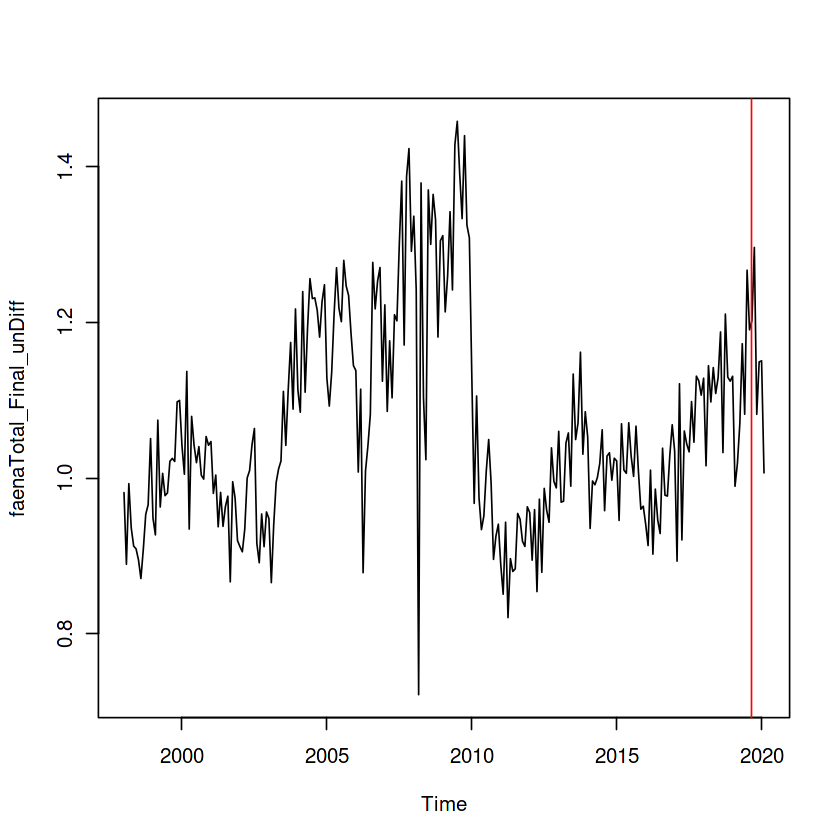

In [48]:
faenaTotal_Final = ts(c(
    fcastFuturo6$endog[,2],
    ts(fcastFuturo6$fcst$faenaTotal[,1], frequency = 12, start = c(2019, 09))
), frequency = 12, start = c(1998, 02))

faenaTotal_Final_unDiff = 10^(diffinv(faenaTotal_Final, xi=log10(0.981503)))
faenaTotal_Final_unDiff

plot(faenaTotal_Final_unDiff)
abline(v=2019.666666666666667, col="red")

#### Consumo Interno

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1998,62.79000,61.58000,62.32000,59.78000,57.04000,60.03000,58.65000,58.12000,61.46000,62.04000,64.45000,66.54000
1999,60.81000,64.32000,67.67000,62.38000,64.22000,63.78000,62.81000,65.90000,69.01000,65.77000,71.55000,67.51000
2000,64.11000,65.73000,69.14000,57.79000,65.35000,65.55000,61.83000,65.00000,65.62000,64.09000,68.62000,65.68000
2001,64.83000,65.91000,62.17000,61.76000,62.29000,63.59000,62.62000,64.45000,58.16000,65.24000,66.06000,59.68000
2002,59.00000,64.78000,57.44000,62.11000,57.97000,65.11000,61.89000,52.13000,53.26000,54.83000,53.81000,54.64000
2003,56.14000,55.23000,54.71000,59.27000,57.22000,60.21000,62.62000,56.62000,64.96000,64.39000,62.07000,67.11000
2004,62.56000,63.30000,66.78000,59.34000,62.50000,65.30000,60.92000,58.74000,63.44000,64.36000,62.43000,63.01000
2005,57.96000,62.60000,57.35000,67.20000,63.31000,59.32000,56.26000,66.23000,65.99000,61.83000,59.89000,60.36000
2006,61.38000,62.03000,58.77000,55.05000,66.98000,67.27000,62.69000,71.03000,65.08000,63.62000,65.46000,60.89000
2007,70.40000,69.01000,66.25000,61.35000,65.82000,68.48000,68.61000,70.13000,61.23000,71.24000,76.00000,69.01000


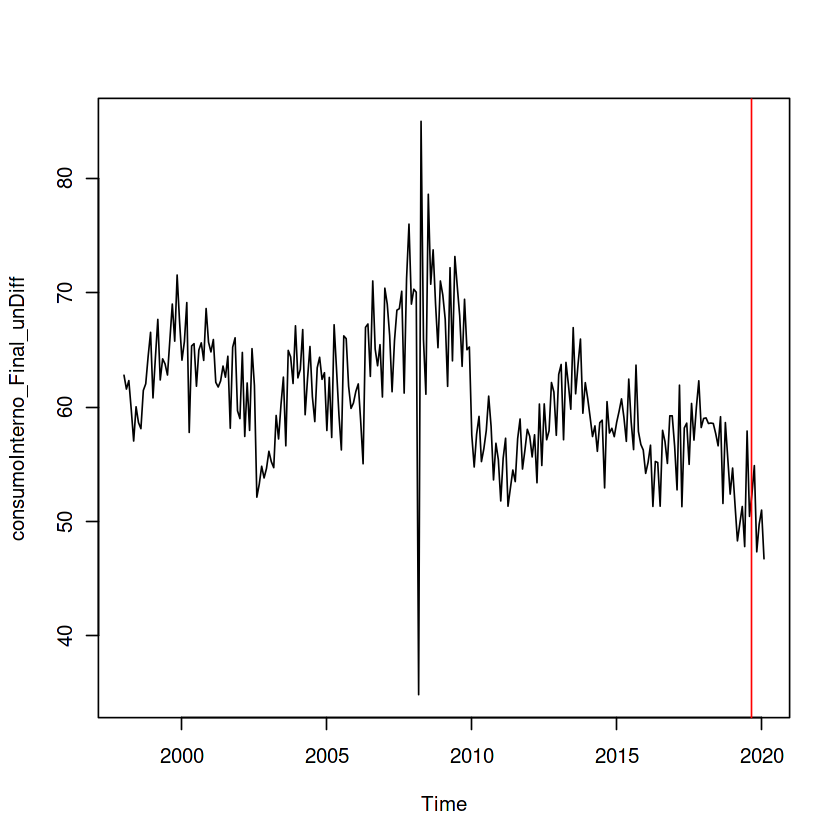

In [49]:
consumoInterno_Final = ts(c(
    fcastFuturo6$endog[,3],
    ts(fcastFuturo6$fcst$consumoInterno[,1], frequency = 12, start = c(2019, 09))
), frequency = 12, start = c(1998, 02))

consumoInterno_Final_unDiff = 10^(diffinv(consumoInterno_Final, xi=log10(62.79)))
consumoInterno_Final_unDiff

plot(consumoInterno_Final_unDiff)
abline(v=2019.666666666666667, col="red")